# OneR To Rule Them All

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2
sns.set()

## Data Sources:
* **2014-2019 race data**: Ergast Developer API F1 race database image: http://ergast.com/mrd/db/
* **"Fun races"**: RaceFans.net Top 100 Races rated by fans: https://www.racefans.net/rate-the-race/f1-fanatic-top-100/. "Fun races" are turbo hybrid-era races (2014-2019) with ratings greater than 8. 
* **"Wet races"**: A Reddit post on r/formula1: https://www.reddit.com/r/formula1/comments/g0plkr/list_of_wet_weather_races_and_wins_by_driver/

## Load data from SQLite database with external query file

In [2]:
db = "f1db_csv/f1db.db"
sqlite_ext_func = "f1db_csv/extension-functions"
sql = "f1db_csv/race-analytics.sql"

# open connection to database, and enable sqlite Extension Functions
conn = sqlite3.connect(db)
conn.enable_load_extension(True)
conn.load_extension(sqlite_ext_func)

# open sql file and read as string
query = open(sql).read()

# load into pandas dataframe
df = pd.read_sql_query(query, conn)

# close connection
conn.close()

In [4]:
df.sample(5)

,raceID,year,race_name,sum_overlapped_by_p1,sum_dnf,stdev_pitstop_cnt,min_overtake,lat,is_wet_race,is_fun_race,is_hamilton_in_podium,avg_podium_driver_age,sum_non_big_3_team_in_podium,sum_non_front_row_in_podium,sum_podium_gap_ms
33,941,2015,2015 Russian Grand Prix,9,7,0.332106,60,43.40570,0,0,1,27.666667,1,2,34871
65,975,2017,2017 Canadian Grand Prix,12,2,0.437237,47,45.50000,0,0,1,29.333333,0,1,55080
105,1015,2019,2019 Monaco Grand Prix,9,1,0.366348,24,43.73470,0,0,1,32.000000,0,1,5764
23,930,2015,2015 Spanish Grand Prix,14,2,0.571241,27,41.57000,0,0,1,29.333333,0,0,62893
73,983,2017,2017 Malaysian Grand Prix,14,2,0.323381,40,2.76083,0,0,1,26.666667,0,1,35289


## EDA

### Current state of formula racing
* Podium gap is trending downward. Given that the podium mostly consists of top 3 teams, it is possible that Ferrari and Red Bull is catching up. Although, it is not as fast as we'd like it to be...
* "Minimum overtake" is defined as the sum of positive position change between qualifying and race result (negative is not included since the sum will produce zero). The actual overtaking might be more than this number, but at least it can be a proxy of how many overtake happened during the race. Despite the closing time gap on the podium, overall number of overtake is trending downward.
* Average podium driver age is trending upward. However, we saw the entry of young new drivers in 2019. They were so promising to the point that it reduces the average podium driver age! Also this is definitely F1's attempt to cater to a younger audience...

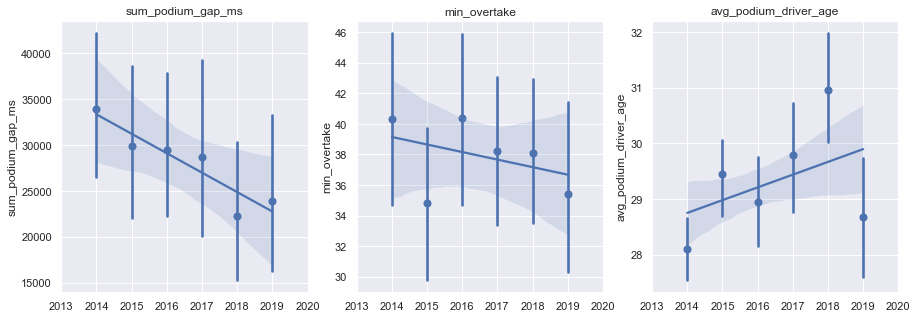

In [5]:
trend_feature = ['sum_podium_gap_ms', 'min_overtake', 'avg_podium_driver_age']

fig, axs = plt.subplots(1, 3, figsize = (15, 5))

for feature, ax in zip(trend_feature, axs.flat): 
    sns.regplot(data=df, x='year', y=feature, x_estimator=np.mean, order=1, ax=ax)
    ax.set_xlim(2013, 2020)
    ax.set(xlabel = None)
    ax.set_title(feature)

plt.show()

### Class balance
'Fun race' is around 20.66% out of all turbo hybrid era races between 2014-2019. Expect nothing if you watch a turbo-hybrid F1 race :)

In [6]:
df['is_fun_race'].mean()

0.2066115702479339

### Wet race
The probability of 'fun race' increases almost twice (from 19% to 36%) if the race is wet. 

In [18]:
wet_xtab = pd.crosstab(df.is_wet_race, df.is_fun_race, normalize = 'index').round(4)*100

wet_xtab[[1]]

is_fun_race,1
is_wet_race,
0,19.09
1,36.36


However, only 9% of all races in the turbo hybrid era are wet.

In [8]:
df['is_wet_race'].mean()

0.09090909090909091

### Hamilton on the podium

Hamilton is probably one of the best driver the sport has ever seen. He is certainly the most dominant driver in the turbo hybrid era.

The probability of 'fun race' increases almost 4 times (from 15% to 42%) if Hamilton is NOT on the podium. You guys are mean!

In [19]:
ham_xtab = pd.crosstab(df.is_hamilton_in_podium, df.is_fun_race, normalize = 'index').round(4)*100

ham_xtab[[1]]

is_fun_race,1
is_hamilton_in_podium,
0,41.67
1,15.46


Aaand.. surprise, surprise. Hamilton is on the podium in 80.16% of all races between 2014-2019...

In [5]:
df['is_hamilton_in_podium'].mean()

0.8016528925619835

### Continuous variables distribution:
#### Variables with no median difference in fun races and non-fun races
* **Latitude of the circuit**: most of races happened in the northern hemisphere anyway. Cannot conclude that European race is more fun just because it is in Europe
* **Average podium driver's age**: average is almost 30 in both cases. It is rare to see young podium sitters. However note that the variance of age is bigger in fun races.
* **Count non-Big 3 team in podium**: median is zero for both cases. Mercedes, Ferrari, and Red Bull is dominating the turbo hybrid era.
* **Count non-front row qualifiers on the podium**: median is 1 in both cases. It is rare to see non-front row qualifiers complete the race as a podium sitter.

#### Variables with median difference in fun races and non-fun races
* **Count overlapped by P1**: fun races have less drivers overlapped by the race winner. Indicates closer racing.
* **Count DNF drivers**: fun races have more DNF drivers, possibly related with chaotic/uncertain conditions.
* **Standard deviation of pitstop count**: fun races have higher pitstop count standard deviation. Indicates different strategies employed by the teams and drivers. Could also indicate uncertain conditions.
* **Sum podium gap in milliseconds**: fun races have smaller finish time gaps between P1-P3. Indicates closer racing.
* **Minimum overtake**: Fun races have more median overtake.

/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


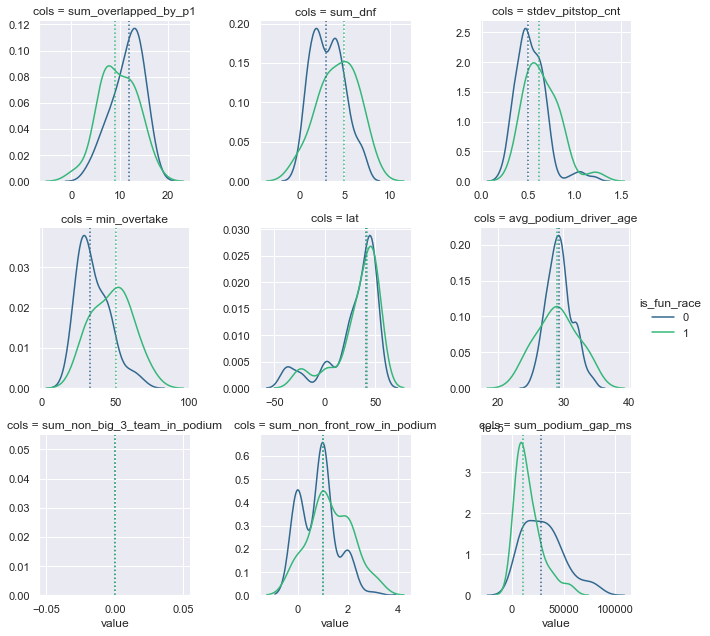

In [10]:
disc_vars = ['year',
             'raceID', 
             'race_name', 
             'is_wet_race', 
             'is_hamilton_in_podium']

long = df.drop(disc_vars, axis = 1).melt(['is_fun_race'], var_name='cols',  value_name='value')

g = sns.FacetGrid(long, col='cols', hue="is_fun_race", palette='viridis', col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value", hist=False)
g = g.map(lambda y, **kw: plt.axvline(y.median(), linestyle='dotted', color = kw.get("color", "g")), 'value')
g = g.add_legend()

## Run OneR on the data
Reference on OneR:
* "Learn Rules from a Single Feature (OneR)", from the book Interpretable Machine Learning: https://christophm.github.io/interpretable-ml-book/rules.html#learn-rules-from-a-single-feature-oner
* R "OneR" package vignette: https://cran.r-project.org/web/packages/OneR/vignettes/OneR.html

Pseudocode (from the IML book):
> The algorithm is simple and fast:
> 1. Discretize the continuous features by choosing appropriate intervals.
> 1. For each feature:
>    * Create a cross table between the feature values and the (categorical) outcome.
>    * For each value of the feature, create a rule which predicts the most frequent class of the instances that have this particular feature value (can be read from the cross table).
>    * Calculate the total error of the rules for the feature.
> 1. Select the feature with the smallest total error.

Let's run the R implementation of OneR algo since it is the best implementation that I found so far.

### Prepare Dataframe
Apparently the OneR package has a quirk: we need to move the target feature to the end of the dataframe

In [12]:
df_prep = df.drop(['raceID', 'race_name', 'year'], axis=1)
df_prep = df_prep[[c for c in df_prep if c not in ['is_fun_race']] + ['is_fun_race']]

df_prep.head()

,sum_overlapped_by_p1,sum_dnf,stdev_pitstop_cnt,min_overtake,lat,is_wet_race,is_hamilton_in_podium,avg_podium_driver_age,sum_non_big_3_team_in_podium,sum_non_front_row_in_podium,sum_podium_gap_ms,is_fun_race
0,11,6,0.471405,63,-37.84970,0,0,28.333333,2,2,56804,0
1,14,5,0.786398,47,2.76083,0,1,28.333333,0,0,41847,0
2,7,6,0.796366,44,26.03250,0,1,27.333333,1,1,25152,1
3,13,2,0.478091,35,31.33890,0,1,30.333333,0,2,41666,0
4,16,2,0.588490,22,41.57000,0,1,27.666667,0,0,49650,0


### Run algorithm

Reference: https://stackoverflow.com/questions/39008069/r-and-python-in-one-jupyter-notebook

Make sure that you have the `rpy2` package loaded. Prior to running the R code, we need to do `%load_ext`. Also, we need the `%%R` magic function to run the R cells.

In [13]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


The OneR algorithm suggests minimum overtake as the best variable to determine whether a race is fun/not. If we have a minimum overtake of at least 53, then the race is fun. This simple rule has 82.64% accuracy. IMO it can serve as a good baseline to beat when you're building a blackbox model.

Although, note that if you predict that all F1 races in turbo-hybrid era as NOT fun, you'll get a 79.34% accuracy anyway (fun races is ~20.66% of all races). Accuracy is not a good metric in imbalanced classification problem. 

In [14]:
%%R -i df_prep -w 5 -h 5 --units in -r 200

## install the OneR package
# install.packages("OneR", repos='https://repo.bppt.go.id/cran/', quiet=TRUE)

# load package
library(OneR)

# bin the continuous data, since OneR only can work on discrete data. The package has optimum binning function
data <- optbin(df_prep, method = "infogain")

# train the model
model <- OneR(data, verbose = TRUE)
summary(model)


    Attribute                    Accuracy
1 * min_overtake                 82.64%  
1   avg_podium_driver_age        82.64%  
3   stdev_pitstop_cnt            81.82%  
4   sum_overlapped_by_p1         79.34%  
4   sum_dnf                      79.34%  
4   lat                          79.34%  
4   is_wet_race                  79.34%  
4   is_hamilton_in_podium        79.34%  
4   sum_non_big_3_team_in_podium 79.34%  
4   sum_non_front_row_in_podium  79.34%  
4   sum_podium_gap_ms            79.34%  
---
Chosen attribute due to accuracy
and ties method (if applicable): '*'


Call:
OneR.data.frame(x = data, verbose = TRUE)

Rules:
If min_overtake = (17.9,52.5] then is_fun_race = 0
If min_overtake = (52.5,74.1] then is_fun_race = 1

Accuracy:
100 of 121 instances classified correctly (82.64%)

Contingency table:
           min_overtake
is_fun_race (17.9,52.5] (52.5,74.1] Sum
        0          * 89           7  96
        1            14        * 11  25
        Sum         103          18